In [1]:
import os
import lmfit
import warnings
import csv
import astropy
import torch

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import lightkurve as lk
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.python.client import device_lib
from wotan.gaps import get_gaps_indexes
from tqdm.notebook import tqdm
from time import process_time
from os import listdir
from os.path import join as opj
from astropy.io import fits

eb_df = pd.read_csv('keplerebs.villanova.edu', skiprows=7)

eb_df = eb_df.loc[(eb_df['morph'] < 0.5) & (eb_df['period'] >= 5)  & (eb_df['morph'] != -1)]
eb_df = eb_df.drop_duplicates(subset=['#KIC'])
eb_df

,#KIC,period,period_err,bjd0,bjd0_err,morph,GLon,GLat,kmag,Teff,SC,Unnamed: 11
1776,5477805,5.006710,0.000011,55067.660282,0.019559,0.18,75.7458,6.2916,13.518,5921.0,False,NaN
1777,10158418,5.007412,0.000011,54958.008628,0.012390,0.13,80.9994,10.3681,13.592,5699.0,True,NaN
1778,7778437,5.014232,0.000011,54966.173727,0.039605,0.32,78.2846,7.6626,13.797,6244.0,True,NaN
1779,10215869,5.017270,0.000057,55002.598791,0.029864,0.24,80.1869,12.0388,14.115,6287.0,False,NaN
1780,12004679,5.042490,0.000011,54955.769983,0.024497,0.24,80.8382,18.4306,13.231,5432.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2915,9408440,989.985000,-1.000000,55346.365980,0.096130,0.00,78.5607,12.2615,13.199,5688.0,False,NaN
2916,8054233,1058.000000,-1.000000,54751.806288,0.968052,0.03,78.6142,7.7321,11.783,4733.0,False,NaN
2917,7672940,1064.270000,-1.000000,54977.092960,0.089646,0.00,74.5296,14.6136,12.328,-1.0,False,NaN
2918,11961695,1082.815000,-1.000000,54871.395674,0.211754,0.02,81.8628,15.9404,13.718,5768.0,False,NaN


LightCurveCollection of 17 objects:
    0: <KeplerLightCurve LABEL="KIC 10020423" QUARTER=1 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    1: <KeplerLightCurve LABEL="KIC 10020423" QUARTER=2 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    2: <KeplerLightCurve LABEL="KIC 10020423" QUARTER=3 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    3: <KeplerLightCurve LABEL="KIC 10020423" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    4: <KeplerLightCurve LABEL="KIC 10020423" QUARTER=5 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    5: <KeplerLightCurve LABEL="KIC 10020423" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    6: <KeplerLightCurve LABEL="KIC 10020423" QUARTER=7 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    7: <KeplerLightCurve LABEL="KIC 10020423" QUARTER=10 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    8: <KeplerLightCurve LABEL="KIC 10020423" QUARTER=9 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    9: <KeplerLightCurve LABEL="KIC 10020423" QUARTER=8 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    10: <Kepl

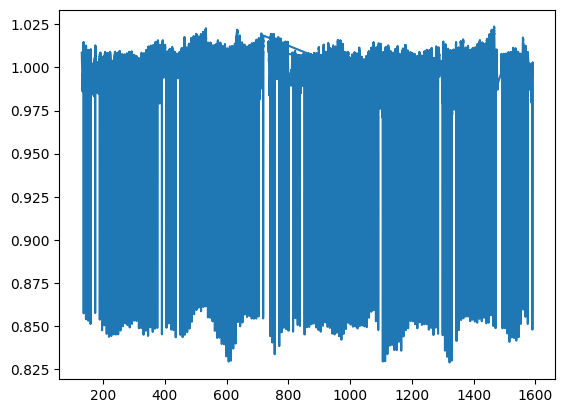

In [2]:
%matplotlib inline

search_result = lk.search_lightcurve('KIC 10020423', author='Kepler',exptime=1800)
lc_collection = search_result.download_all(quality_bitmask="hard")
print(lc_collection)

index = 15
lc = lc_collection[index]
lc_stich = lc_collection.stitch()
lc = lc_stich.remove_nans()

plt.figure()
plt.plot(lc.time.bkjd,lc.flux.value)

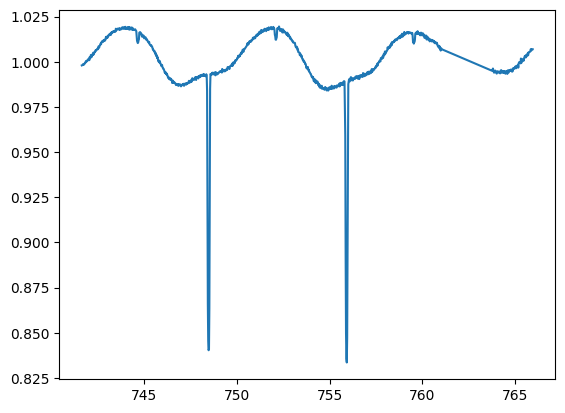

In [3]:
plt.figure()
plt.plot(lc.time.bkjd[35000:36000],lc.flux.value[35000:36000])

In [4]:
def fold_and_bin(time, flux, periods, n_bins, t0=0.0, device='cpu', batch_size=1000, adaptive_bin_widths=True):

    return pytorch_fold_and_adaptive_bin(time, flux, periods, n_bins, t0, device, batch_size)

def pytorch_fold_and_adaptive_bin(time, flux, periods, n_bins, t0=0.0, device='cpu', batch_size=1000):
    
    """
    Fold and bin a light curve using GPU-accelerated operations.
    
    Time cost: 100,000 folds with 256 bins takes ~5 s using an RTX 2080 Ti GPU
    
    Upon first use of this function in a notebook or script, it will allocate the 
    memory it needs, then keep that memory occupied, even when it finishes. I have
    not figured out how to release the GPU memory upon completion. This has unfortunate 
    implications for its use. For example, you might need to do folding as a 
    standalone step, then do neural network things later, after the folding 
    script or notebook has been shut down and the memory released.
    
    INPUTS:
    time - the time array of the light curve
    flux - the flux array of the light curve
    periods - an array of periods to fold at
    n_bins - how many datapoints (bins) per fold (more is faster)
    device - which GPU to use for the operation
    batch_size - how many folds to perform at once. This exists
                 because GPU cant fit all the arrays in memory
                 so we must do the operation in batches.
    
    OUTPUTS:
    bin_averages - the binned folds. Shape=(N_periods, N_bins)
    
    Kevin Willis 20231104
    """
    
    def create_batch_indices(total_samples, batch_size):
    
        n_batches = total_samples // batch_size

        complete_batches = [[i, i + batch_size] for i in range(0, n_batches * batch_size, batch_size)]

        if total_samples % batch_size != 0:

            incomplete_batch = [n_batches * batch_size, total_samples]

            complete_batches.append(incomplete_batch)

        return complete_batches
    
    # Importing pytorch and telling it to not save gradient info, since this is not neural network (NN) related
    # This may be problematic if you use this function in the same script/notebook as a pytorch NN. 
    # If so, solutions likely exist.
    import torch
    torch.autograd.set_grad_enabled(False)
    torch.set_grad_enabled(False)

    if isinstance(periods, float): 
        periods = np.array([periods])
        
    elif isinstance(periods, list): 
        periods = np.array(periods)
    
    tensor_args = dict(dtype=torch.float32, device=device)

    # -------------------------------------------
    
    # Ensure all time and flux are finite values
    gi = np.isfinite(time) & np.isfinite(flux)
    
    points_per_bin = int(np.floor(np.count_nonzero(gi) / n_bins))

    resize = int(np.floor(n_bins * points_per_bin))
    
    # Resize (crop) arrays so that their length is a factor of the bin quantity
    t = time[gi][:resize]#.copy()
    f = flux[gi][:resize]#.copy()

    # Convert to tensors on the GPU 
    t = torch.as_tensor(t - t0, **tensor_args)  # Subtract t0 to center the light curve
    f = torch.as_tensor(f, dtype=torch.float64, device=device)
    
    # Allocate space for the final product, the folds (can be a huge array)
    bin_averages = torch.ones((len(periods), n_bins), dtype=torch.float64, device=device)
    
    # Split the job into smaller batches since GPU can do entire operation at once
    batch_idxs = create_batch_indices(len(periods), batch_size)
    
    for batch_num, be in enumerate(tqdm(batch_idxs, leave=False, desc='Fold batch #')):
        
        # Which periods to fold at in this batch
        slice_range = range(be[0], be[1])
        
        # Move periods to GPU memory
        periods_gpu = torch.as_tensor(periods[slice_range], **tensor_args)
        
        # For each fold, calculate the phases for each data point in the LC
        phi_all = t.unsqueeze(0) / periods_gpu.unsqueeze(1) + 0.5
        
        phi_all.sub_(torch.floor(phi_all))

        # Sort each row and get the sorted indices
        sorted_indices = torch.argsort(phi_all, dim=1)

        # Sort flux values by phases of each fold
        expanded_flux = f.unsqueeze(0).expand(sorted_indices.size(0), -1)

        sorted_flux = torch.gather(expanded_flux, 1, sorted_indices)
        
        kernel = torch.ones((1, 1, 1, points_per_bin), dtype=torch.float64, device=device)

        # Calculate bin sums (Says bin averages, but will reuse variable later to get averages)
        bin_averages[slice_range, :] = torch.nn.functional.conv2d(
            input=sorted_flux.unsqueeze(0).unsqueeze(0),
            weight=kernel,
            stride=(1, points_per_bin),
            padding=0,
        )[0, 0, :, :]
    
    # Calculate bin averages
    bin_averages.div_(torch.as_tensor(points_per_bin, **tensor_args))
    
    bin_averages = np.squeeze(bin_averages.cpu().numpy()) # 2D to 1D if only 1 period given
    
    return bin_averages

In [5]:
# with tf.device(proc_hardware_name):
#     model = load_model("./model_single_v3_save1.hd5") #WITHOUT FOLDING

In [5]:
#Table for all accessible transit times
#BKJD is -2454833.0

#Kepler-413: BJD - 2455000
k413 = np.array([-4.3799,62.3363,125.0938,963.1529,1026.1544,1092.3978,1156.2889,1219.5674])

#Kepler-453: BJD - 2455000
k453 = np.array([781.8239,1019.1749,1254.7319])

#Kepler-64: BJD - 2455000
k64 = np.array([70.80674,207.44916,344.11218,479.98746,613.17869,749.20260,885.91042])

#Kepler-1661: BJD - 2455000
k1661 = np.array([804.8008,975.0972,1145.5076])

#Kepler-38: BJD - 2455000
k38 = np.array([36.10896,244.00847,451.93756,659.71862,762.33371,867.38194])

#Kepler-47: BJD - 2455000
#b
k47b = [-30.80969,65.24832,112.54179,160.89953,208.84796,256.34222,305.14101,352.25457,401.35072,448.43586,497.42556,544.73196,593.25486,688.66867,
     737.27699,784.46811,880.61567,976.86285,1025.61184,1120.93797,1216.66103,1265.68597,1361.87205,1408.96020]
#d
k47d = [604.43883,790.88576,977.36103,1163.84405,1350.36851]
#c
k47c = [246.65182,550.47424,850.97978,1154.79184]

k47 = np.array([-30.80969,65.24832,112.54179,160.89953,208.84796,256.34222,305.14101,352.25457,401.35072,448.43586,497.42556,544.73196,593.25486,
                688.66867,737.27699,784.46811,880.61567,976.86285,1025.61184,1120.93797,1216.66103,1265.68597,1361.87205,1408.96020,604.43883,
                790.88576,977.36103,1163.84405,1350.36851,246.65182,550.47424,850.97978,1154.79184])

k413 = k413 + 167
k453 = k453 + 167
k64 = k64 + 167
k1661 = k1661 + 167
k38 = k38 + 167
k47 = k47 + 167

In [6]:
#Definitions
def load_and_clean(kic):
    '''
    Retrieves light curve and associated parameters of a Kepler target using the Kepler archive and MAST keplerebs record.

    INPUTS:
    kic - Kepler Input Catalog index of the target

    OUTPUTS:
    lc - target light curve, as a LightKurve object
    t - target time series, as a Numpy array
    f - target flux intensity, as a Numpy array
    ferr - target measurement uncertainty, as a Numpy array
    p - target eclipsing binary period, in days
    t0_1 - BKJD position of primary eclipse, in days
    '''
    
    #Load lightcurve
    search_result = lk.search_lightcurve(f'KIC {kic}', author='Kepler', exptime=1800)
    lc_collection = search_result.download_all(quality_bitmask="hard")
    lc_stitch = lc_collection.stitch()
    lc = lc_stitch.remove_nans()
    params = eb_df.loc[eb_df['#KIC'] == kic]
    f = lc.flux.value

    #Run a 5-sigma clip to trim off obvious flux errors (check to ensure functionality with long-period eclipses)
    clip_limit = 1 + 5*np.std(f)
    clip = np.abs(f) < clip_limit
    f = f[clip]
    t = lc.time.bkjd[clip]
    ferr = lc.flux_err.value[clip]

    #Get period and BKJD t0 of primary eclipse
    p = params['period'].item()
    t0_1 = params['bjd0'].item() - 54833
    
    return lc, t, f, ferr, p, t0_1
    
    
def get_parameters(t, f, p):
    '''
    Retrieves orbital parameters (duration, t0) for both components of an eclipsing binary. If a detectable secondary eclipse is absent, 
    returns None for secondary's parameters.

    INPUTS:
    t - target time series, as a Numpy array
    f - target flux intensity, as a Numpy array
    p - target eclipsing binary period, in days

    OUTPUTS:
    dur_prim - length of primary eclipse, in days
    dur_sec - length of secondary eclipse, in days
    t0_2 - BKJD position of secondary eclipse, in days
    '''
    
    num = int(p*48)

    #Fold light curve - EXTENRAL
    sample_fold = fold_and_bin(t, f, [p], num, t0=t0_1+p/4, device='cpu', batch_size=1000, adaptive_bin_widths=True)
    gradient = np.gradient(np.gradient(sample_fold))
    sec = gradient[num//2:num]

    #Get pixel indices of relative minima
    idx1, idx2 = np.argpartition(gradient[0:num//2], 1)[0:2]
    idx3, idx4 = np.argpartition(sec, 1)[0:2] + num//2

    #Convert to time in days
    dur_prim = (np.abs(idx1 - idx2) + 22)/48
    dur_sec = (np.abs(idx3 - idx4) + 22)/48
    t0_2 = t0_1 + ((idx4+idx3) - (idx2+idx1))/96
    
    #Filter out grazing binaries
    if sec[idx3 - num//2] > (-3*np.std(sec)):
        return dur_prim, None, None
    
    return dur_prim, dur_sec, t0_2


def find_transits(time_norm, flux_norm):
    '''
    Uses an external convolutional neural network to search detrended light curve for planetary transits.

    INPUTS:
    time_norm - detrended target time series, as a Numpy array
    flux_norm - detrended target flux intensity, as a Numpy array

    OUTPUTS:
    segment_times - time indices of detections, as a Numpy array
    y_pred - model output confidence for all segments, as a Numpy array
    sample_matrix - set of sample segments, as a Numpy array
    '''
    
    #NOTE: Optimized CNN might use different window length? Adjust if needed.
    segment_transform = []
    segment_times = np.array([])

    #Divide lightcurve series into 240-point segments
    for i in range(len(flux_norm)//240):
        segment = flux_norm[240*i:240*(i+1)]
        segment_times = np.append(segment_times, time_norm[240*i])
        
        #Stretch vertically & invert
        sigma = np.std(segment)
        segment_norm = (1 - segment) / (2*sigma)
        segment_transform.append(segment_norm)
        
    #Reshape 3D matrix to desired dimensions
    sample_matrix = np.vstack(segment_transform)
    sample_matrix = sample_matrix.reshape((sample_matrix.shape[0], sample_matrix.shape[1], 1))
    
    #Generate prediction matrix with model
    with tf.device(proc_hardware_name):
        y_pred = np.reshape(model.predict(sample_matrix),(i+1))
        
    return segment_times, y_pred, sample_matrix


def split_lc(time, flux, other_arrs=[], time_gap_delta=0.75, flux_gap_delta=0.05, min_chunk_len=30, verbose=False):
    '''
    Identifies positions of data gaps within target Kepler lightcurve, then splits target time & flux series into 
    segments at those positions.

    INPUTS:
    time - target time series, as a Numpy array
    flux - target flux intensity, as a Numpy array
    other_arrs - other target data series to split, as a list of Numpy arrays
    time_gap_delta - maximum allowable gap in time series, in days
    flux_gap_delta - maximum allowable gap in flux series
    min_chunk_len - minimum length of chunks, in datapoints

    OUTPUTS:
    split_ixs - positions of light curve splits, as a Numpy array
    time_chunks - chunked time series, as a Numpy array
    flux_chunks - chunked flux series as a Numpy array
    '''
    
    #Eliminate NaNs from time and flux arrays
    gi = np.isfinite(time) & np.isfinite(flux)    
    time_clean = time[gi]
    flux_clean = flux[gi]
    
    #Clean other_arrs
    for i in range(len(other_arrs)):
        if i == 0: other_arrs_clean = []
        other_arrs_clean.append( other_arrs[i][gi] )
    
    #Get flux and time gaps
    dt = np.abs(np.diff(time_clean))
    df = np.abs(np.diff(flux_clean))
    split_ixs = np.argwhere( (dt > time_gap_delta) | (df > flux_gap_delta) ).flatten() + 1
    
    if verbose:
        print(f'Time gaps found = {np.count_nonzero(dt > time_gap_delta)}')
        print(f'Flux gaps found = {np.count_nonzero(df > flux_gap_delta)}')
        print(f'Tot. gaps found = {len(split_ixs)}')
    
    #Split time and flux arrays according to the locations of all gaps
    if len(split_ixs) > 0:
        time_chunks = np.array(np.split(time_clean, split_ixs), dtype=object)
        flux_chunks = np.array(np.split(flux_clean, split_ixs), dtype=object)
    else:
        time_chunks = [time_clean]
        flux_chunks = [flux_clean]
    
    #Split other arrays according to gap locations
    for i in range(len(other_arrs)):
        if i == 0:
            other_arrs_chunks = []
        if len(split_ixs) > 0:
            other_arrs_chunks.append(np.array(np.split(other_arrs_clean[i], split_ixs), dtype=object))
        else:
            other_arrs_chunks.append([other_arrs_clean[i]])
    
    #Filter out chunks with insuficient length
    if len(split_ixs) > 0:
        chunk_lens = np.array([len(chunk_data) for chunk_data in time_chunks])
        good_chunks = chunk_lens > min_chunk_len   
        time_chunks = time_chunks[good_chunks]
        flux_chunks = flux_chunks[good_chunks]
        for i in range(len(other_arrs)):
            other_arrs_chunks[i] = other_arrs_chunks[i][good_chunks]

    if len(other_arrs) > 1:
        return time_chunks, flux_chunks, other_arrs_chunks

    return split_ixs, time_chunks, flux_chunks

Fold batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Time gaps found = 51
Flux gaps found = 0
Tot. gaps found = 51


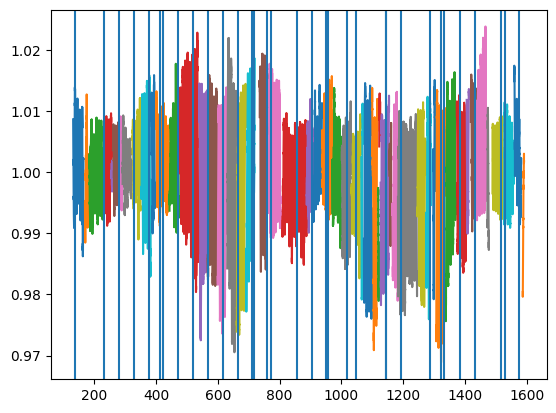

In [7]:
import scipy.fftpack

kic = 10020423
lc, t, f, ferr, p, t0_1 = load_and_clean(kic)
dur_prim, dur_sec, t0_2 = get_parameters(t, f, p)

if t0_2:
    mask = lc.create_transit_mask(transit_time = [t0_1, t0_2], period = [p, p], duration = [dur_prim, dur_sec])
else:
    mask = lc.create_transit_mask(transit_time = t0_1, period = p, duration = dur_prim)

f[mask] = np.interp(t[mask], t[~mask], f[~mask])

split_ixs, time_chunks, flux_chunks = split_lc(t,f,verbose=True)
for index in range(len(flux_chunks)):
    current_chunk = flux_chunks[index]
    length_arr = np.arange(len(current_chunk))

    plt.plot(time_chunks[index],current_chunk)

for pos in k47:
    plt.axvline(pos)

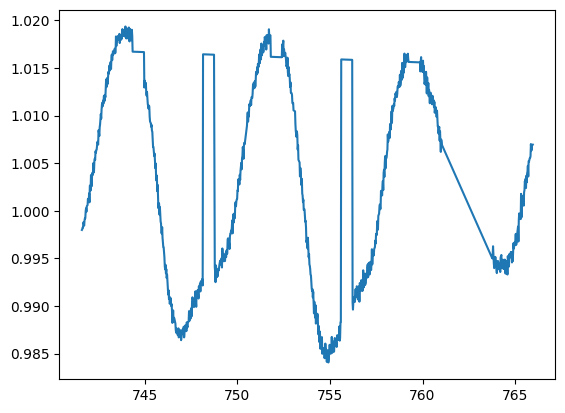

In [8]:
plt.figure()
plt.plot(t[35000:36000],f[35000:36000])

In [15]:
kic = 10020423
lc, t, f, ferr, p, t0_1 = load_and_clean(kic)

None in f

False

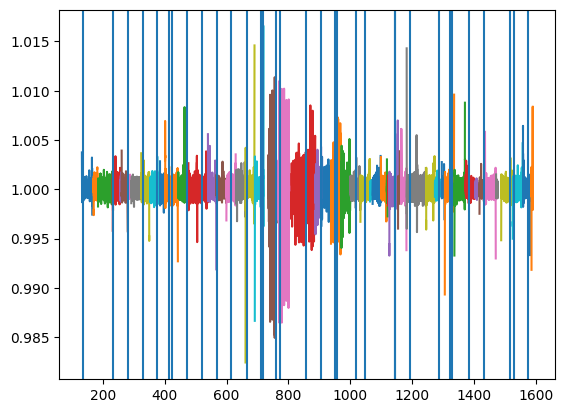

In [16]:
def perform_fft(data_raw):
    #Required: raw dataset array data_raw
    
    #Re-center data array around 0
    data = data_raw - np.mean(data_raw)
    
    #Perform FFT
    fft_result = np.fft.fft(data)
    frequencies = np.fft.fftfreq(len(fft_result), 1)
    
    #Get magnitude of positive FFT portion
    magnitude = np.abs(fft_result)
    magnitude = magnitude[0:len(magnitude)//2]
    
    #Returns: complex ndarray (complex FFT) fft_result | array (frequency magnitude array) magnitude
    return fft_result, magnitude

def invert_fft(fft, fft_mag, bound):
    #Required: complex FFT array fft, FFT magnitude array fft_mag, integer cutoff (in pixels post-peak) bound
    
    #Find cutoff using numpy argmax
    bound_index = np.argmax(fft_mag) + bound
    
    #Cut FFT array 
    fft[bound_index:-bound_index] = 0
    
    #Restore to original with upper degrees trimmed off
    inverse = np.fft.ifft(fft)
    
    #Returns: complex ndarray (inverse reduced-degree FFT restoration) inverse
    return inverse
    
plt.figure()
time_norm = np.array([])
flux_norm = np.array([])

for i in range(len(flux_chunks)):
    chunk = flux_chunks[i]
    (fft_result, mag) = perform_fft(chunk)
    inverse = invert_fft(fft_result, mag, 20)

    time_norm = np.append(time_norm,time_chunks[i])
    flux_norm = np.append(flux_norm,chunk-inverse.real-np.mean(chunk)+1)
    plt.plot(time_chunks[i],chunk-inverse.real-np.mean(chunk)+1)
    
for pos in k47:
    plt.axvline(pos)

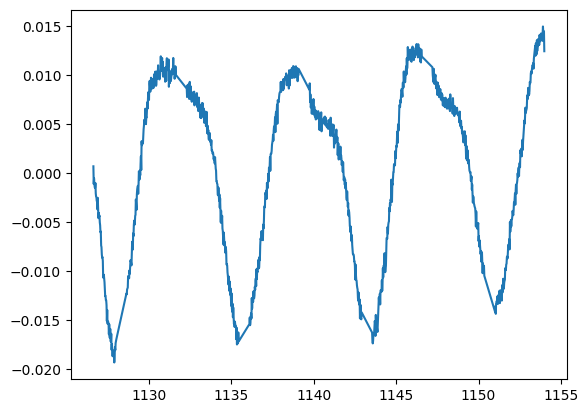

In [29]:
plt.figure()

#WIP - Segments index 20-26 in Kepler-47 lc are affected by unknown masking error.
i = 34
chunk = flux_chunks[i]
(fft_result, mag) = perform_fft(chunk)
inverse = invert_fft(fft_result, mag, 22)

plt.plot(time_chunks[i],chunk-np.mean(chunk))
# plt.plot(inverse)
# plt.plot(chunk-np.mean(chunk)-inverse,'-g')

2024-06-14 18:38:35.280204: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-06-14 18:38:35.673376: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


0.0
1.0081599e-12
0.0
0.0
1.5862676e-15
0.99999106
2.169901e-14
6.0132594e-25
0.0
4.0069843e-22
2.363634e-35
1.1678754e-14
1.62327e-17
0.0
0.9926172
6.6753833e-29
2.1407854e-16
5.7125006e-11
4.2500167e-10
1.5557695e-16
0.0
6.478939e-38
0.99999976
2.2733974e-27
0.0
1.585116e-33
Stats for KIC 10020423
[6, 2, 26, 225]
Precision: 0.75
Recall: 0.1875


<IPython.core.display.Javascript object>


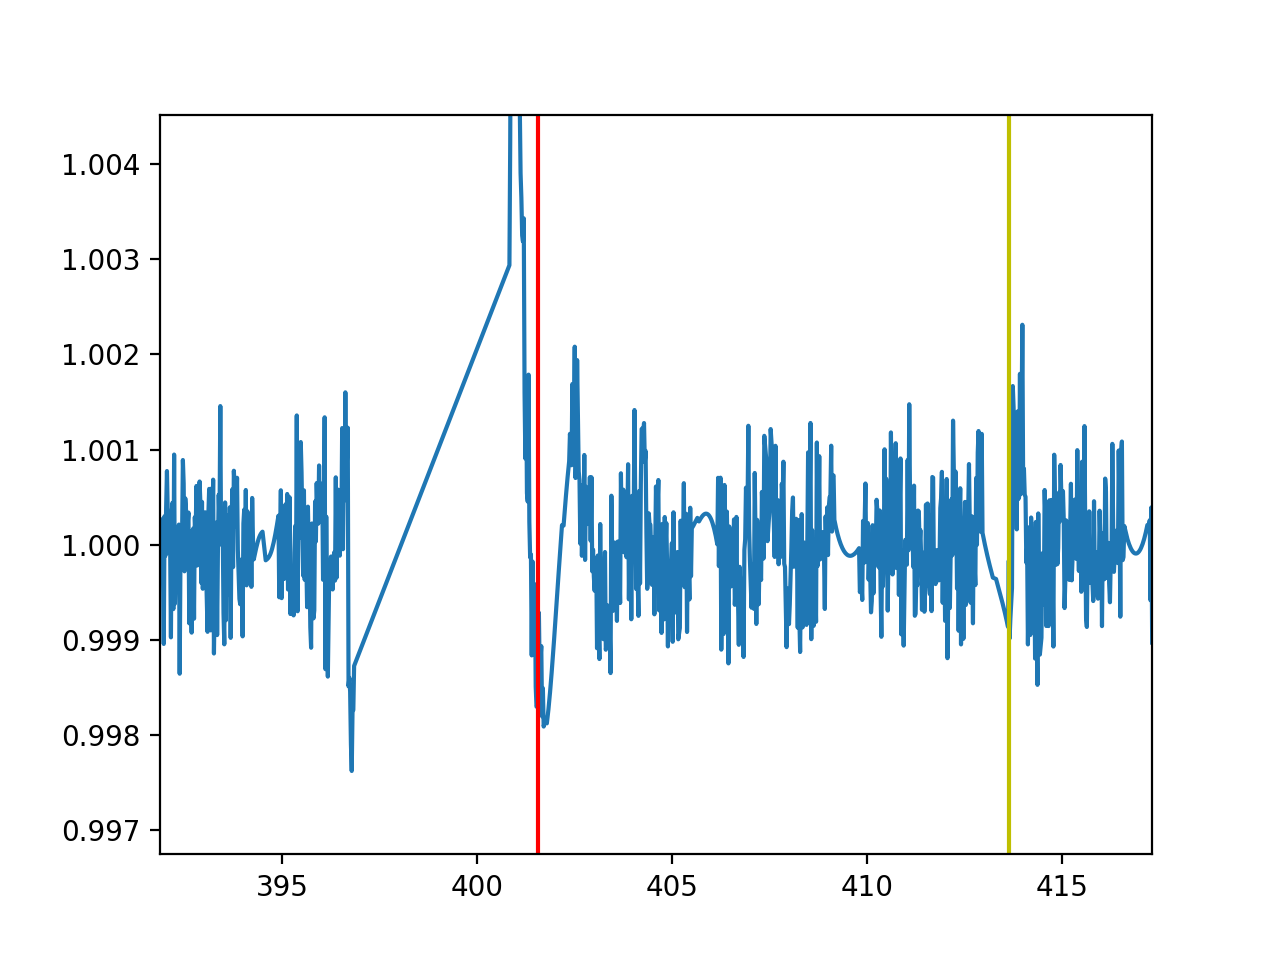

In [34]:
# plt.figure()
# plt.plot(flux_norm)

times, y_pred, sample_matrix = find_transits(time_norm, flux_norm)
tlist_n = k47

tp = 0
fp = 0
tn = 0
fn = 0

tp_list = np.array([])
fp_list = np.array([])
fn_list = np.array([])

gap_segments = split_ixs//240

for i in range(len(times)-1):
    if np.any((tlist_n > times[i])&(tlist_n < times[i+1])):
        if y_pred[i] == 1:
            tp += 1
            idx = tlist_n[(tlist_n > times[i])&(tlist_n < times[i+1])]
            tp_list = np.append(tp_list,idx)
        else:
            fn += 1
            print(y_pred[i])
            idx = tlist_n[(tlist_n > times[i])&(tlist_n < times[i+1])]
            fn_list = np.append(fn_list,idx)
    else:
        if y_pred[i] == 1 and i not in gap_segments:
            fp += 1
            fp_list = np.append(fp_list,times[i])
        else:
            tn += 1

print(f'Stats for KIC {kic}')
print([tp, fp, fn, tn])
print(f'Precision: {tp/(tp+fp)}')
print(f'Recall: {tp/(tp+fn)}')


plt.figure()

# plt.plot(lc.time.bkjd,lc.flux.value)
# plt.plot(t,f)
plt.plot(time_norm,flux_norm)

for index in tp_list:
    plt.axvline(index, color='g')
for index in fn_list:
    plt.axvline(index, color='y')
for index in fp_list:
    plt.axvline(index, color='r')

<IPython.core.display.Javascript object>


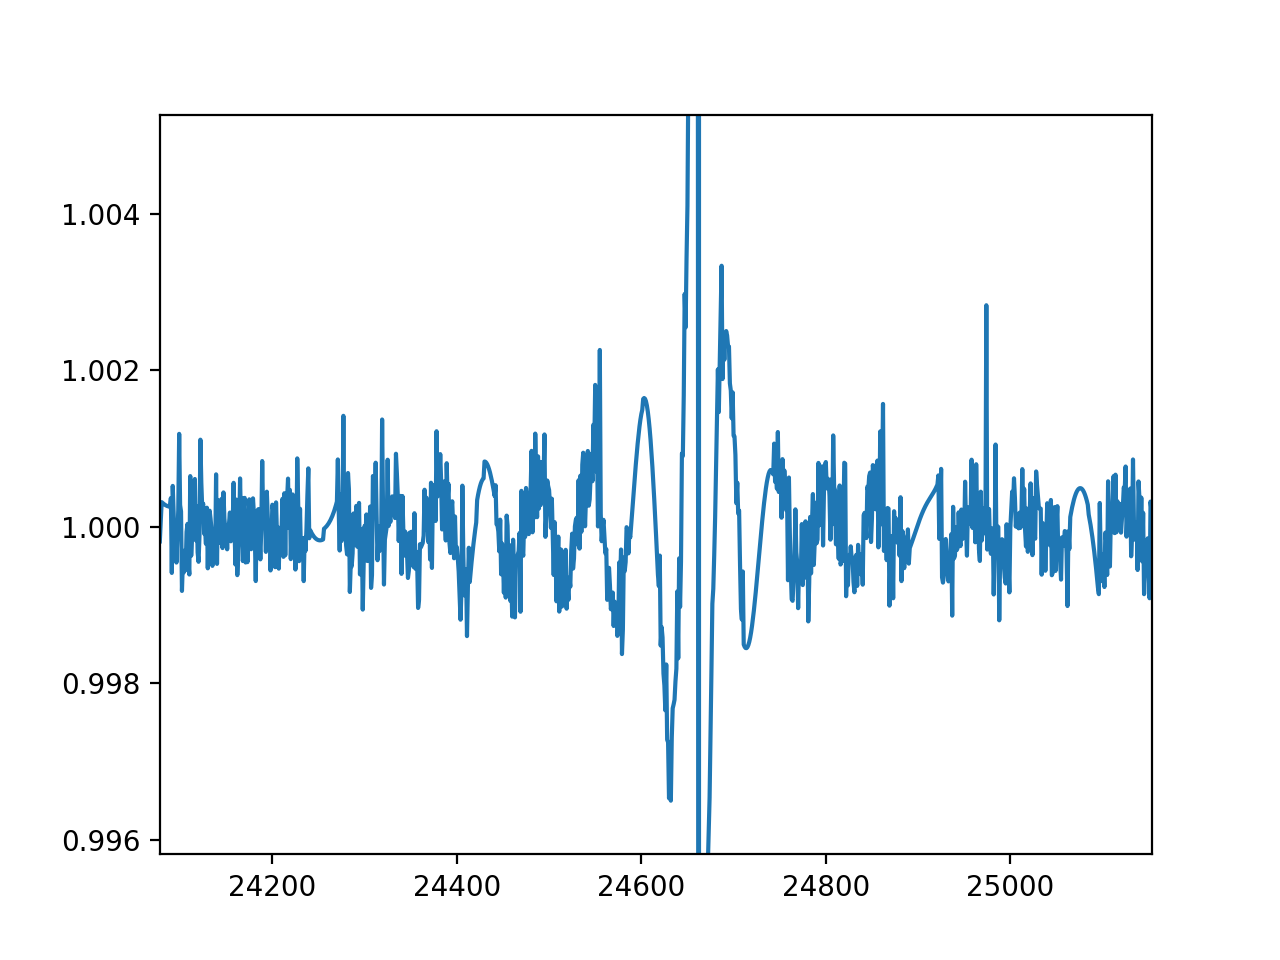

In [25]:
plt.figure()
plt.plot(flux_norm)
for i in split_ixs:
    plt.axvline(i)

<IPython.core.display.Javascript object>


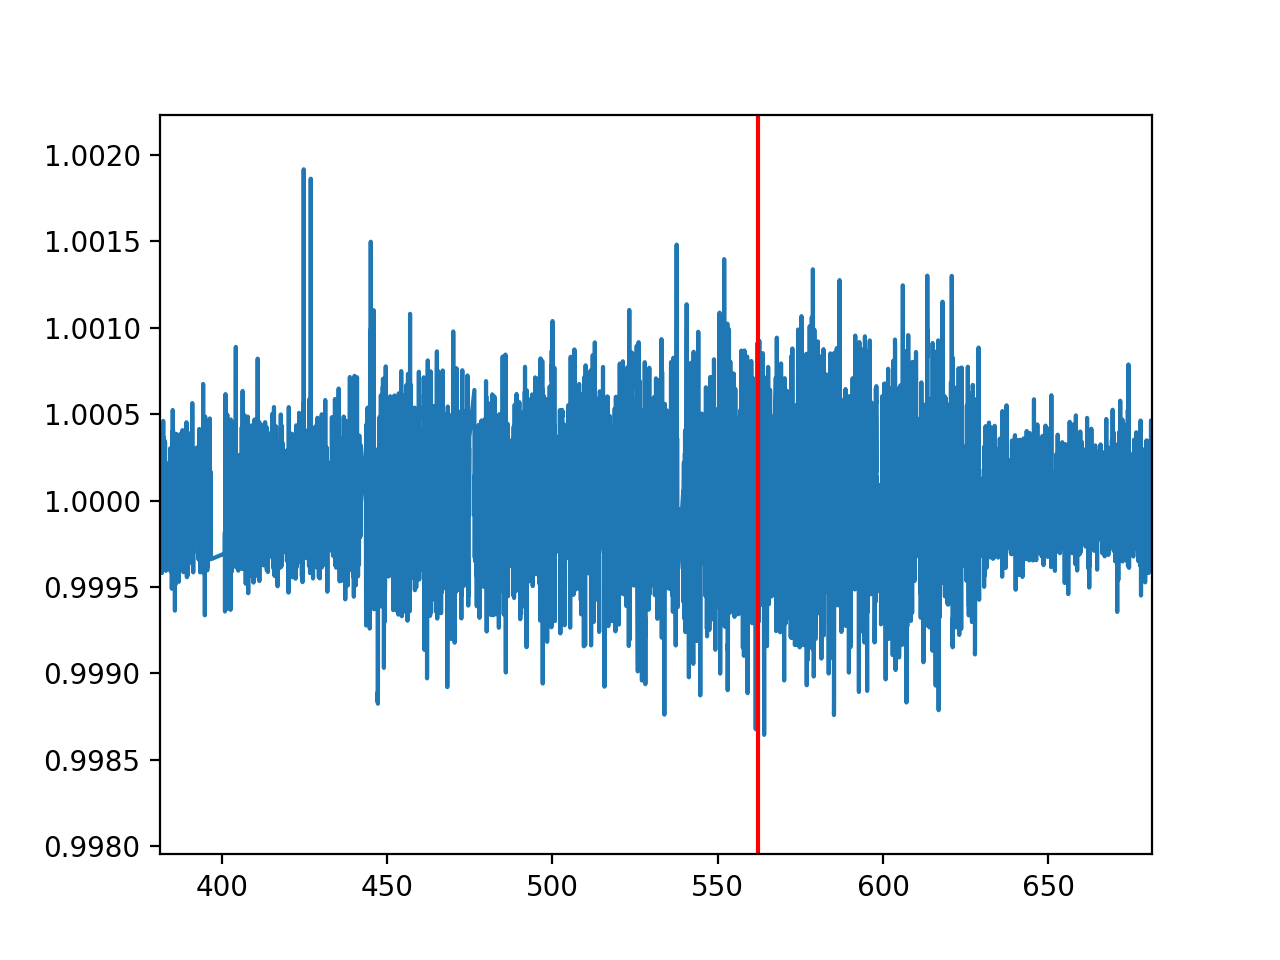

'\nNotes\n\nKepler-38/KIC 6762829: 0|0 Transits are too wide, smoothed out aggressively. Need to run on a lower resolution detrend.\nKepler-413/KIC 12351927: 0.5|0.8 Missing transits are probably undetectable?\nKepler-453/KIC 9632895: 0.2727|1 None missing, false positives caused by elevated noise/bad data gaps\nKepler-1661/KIC 6504534: 0.136|1 Numerous 1-point spikes \n'

In [15]:
plt.figure()

# plt.plot(lc.time.bkjd,lc.flux.value)
# plt.plot(t,f)
plt.plot(time_norm,flux_norm)

for index in tp_list:
    plt.axvline(index, color='g')
for index in fn_list:
    plt.axvline(index, color='y')
for index in fp_list:
    plt.axvline(index, color='r')
    
    
'''
Notes

Kepler-38/KIC 6762829: 0|0 Transits are too wide, smoothed out aggressively. Need to run on a lower resolution detrend.
Kepler-413/KIC 12351927: 0.5|0.8 Missing transits are probably undetectable?
Kepler-453/KIC 9632895: 0.2727|1 None missing, false positives caused by elevated noise/bad data gaps
Kepler-1661/KIC 6504534: 0.136|1 Numerous 1-point spikes 
'''

<IPython.core.display.Javascript object>


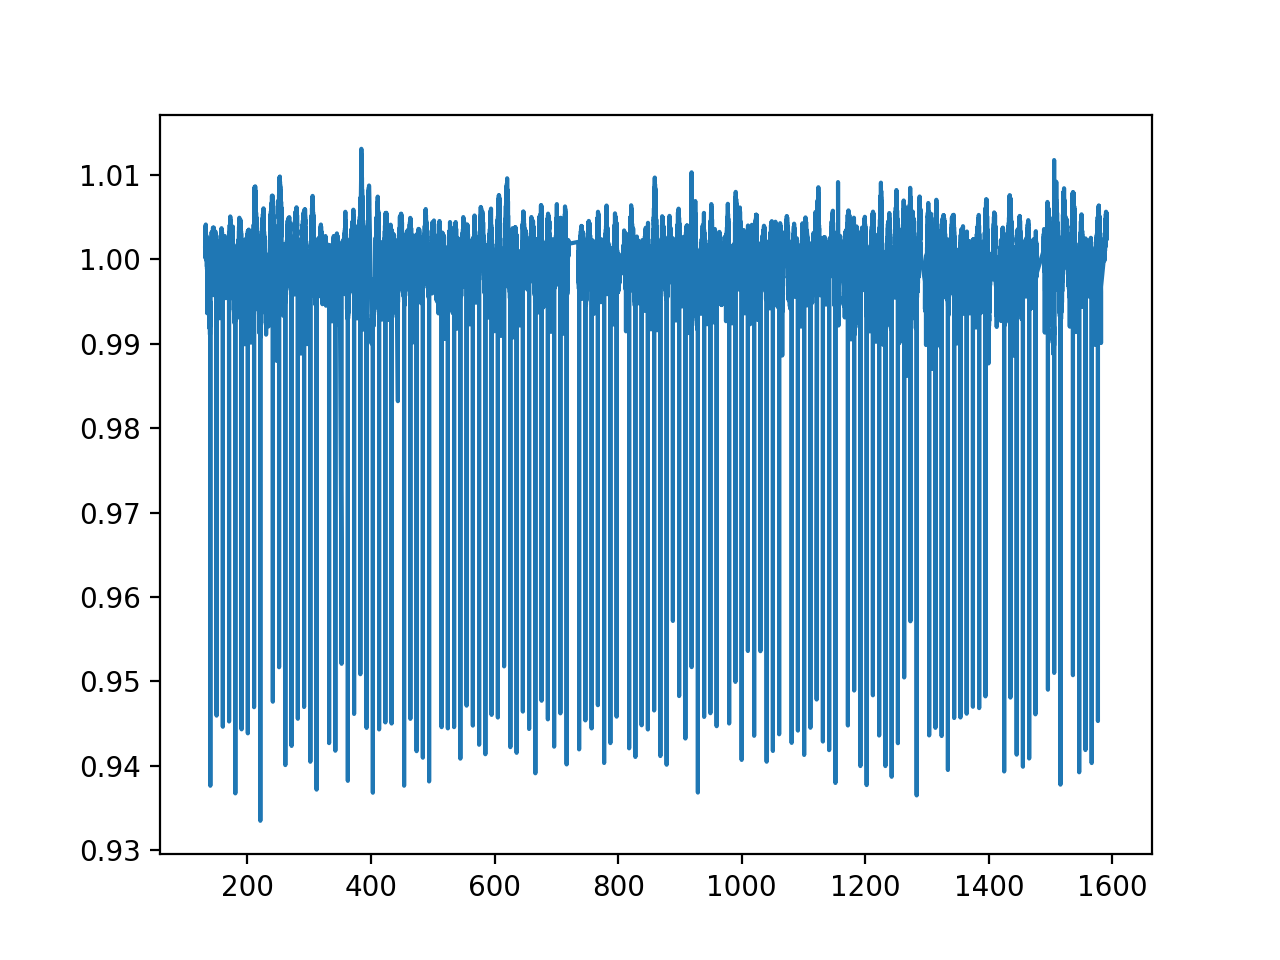

Total Computational time (s):  1160.0827139999978


In [36]:
#Load light curve from Kepler data products

kic = 12351927

plt.figure()

t1_start = process_time()

lc = load_kepler_light_curve(kic=kic, quarters=range(18), cadence='long', quality_bitmask='hard', kid=None, return_file_dirs=False, verbose=False)
params = eb_df.loc[eb_df['#KIC'] == kic]
t = lc.time.bkjd
f = lc.flux.value

t1_stop = process_time()
print("Total Computational time (s): ", (t1_stop-t1_start)*1000)

plt.plot(lc.time.bkjd, lc.flux.value)

Fold batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Total Computational time (s):  245.30077200000733


<IPython.core.display.Javascript object>


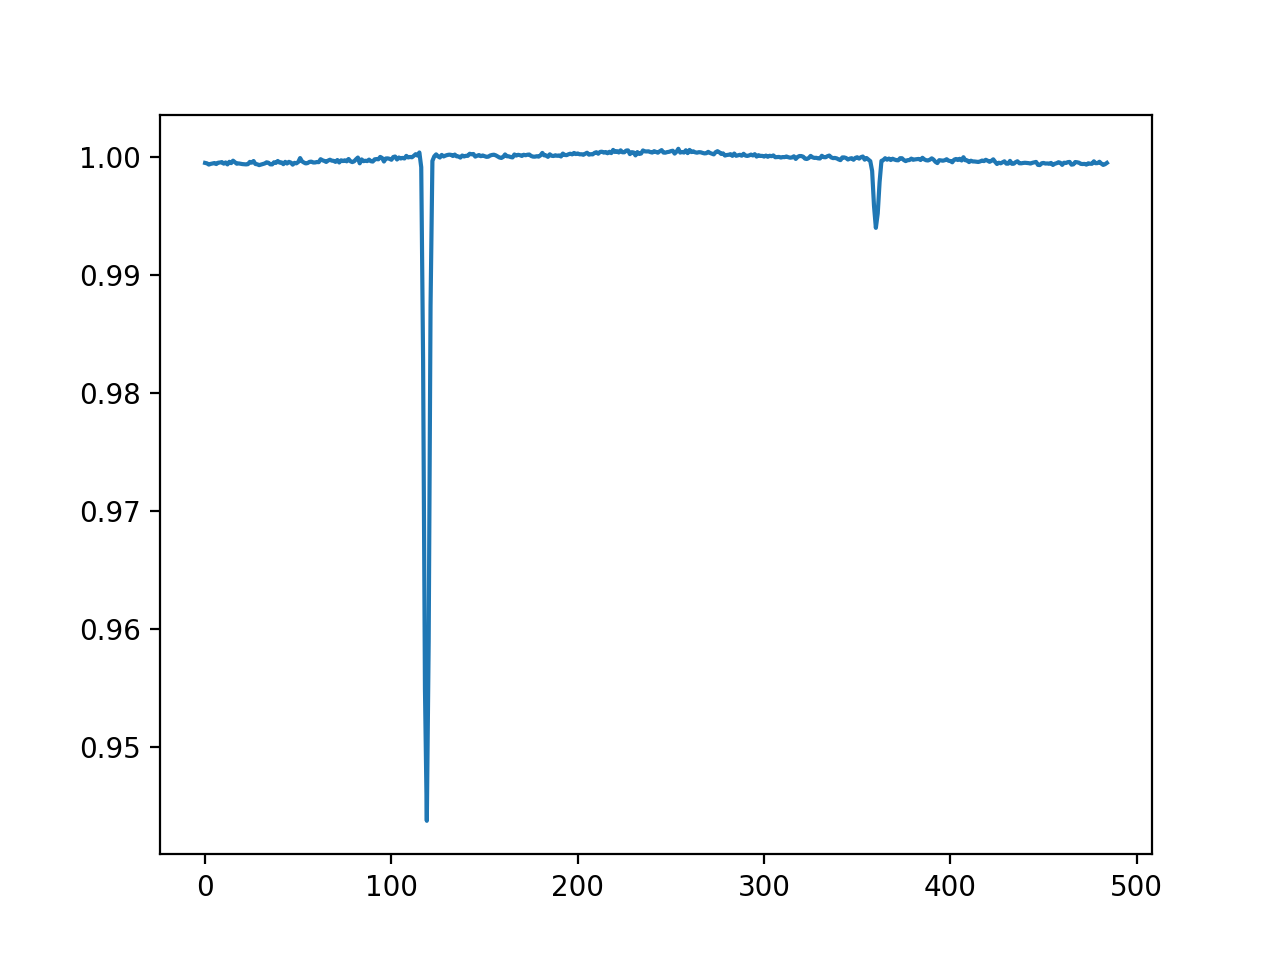

In [37]:
t1_start = process_time()
#New Step - Clip ~5sigma to eliminate spurious elements
clip_limit = 1 + 5*np.std(f)
clip = np.abs(f) < clip_limit
f = f[clip]
t = t[clip]

p = params['period'].item()
t0_1 = params['bjd0'].item() - 54833
num = int(np.floor(p*48))

sample_fold = fold_and_bin(t, f, [p], num, t0=t0_1+p/4, device='cpu', batch_size=1000, adaptive_bin_widths=True)

t1_stop = process_time()
print("Total Computational time (s): ", (t1_stop-t1_start)*1000)
plt.figure()
plt.plot(sample_fold)

Total Computational time (s):  0.7159910000069658
False


<IPython.core.display.Javascript object>


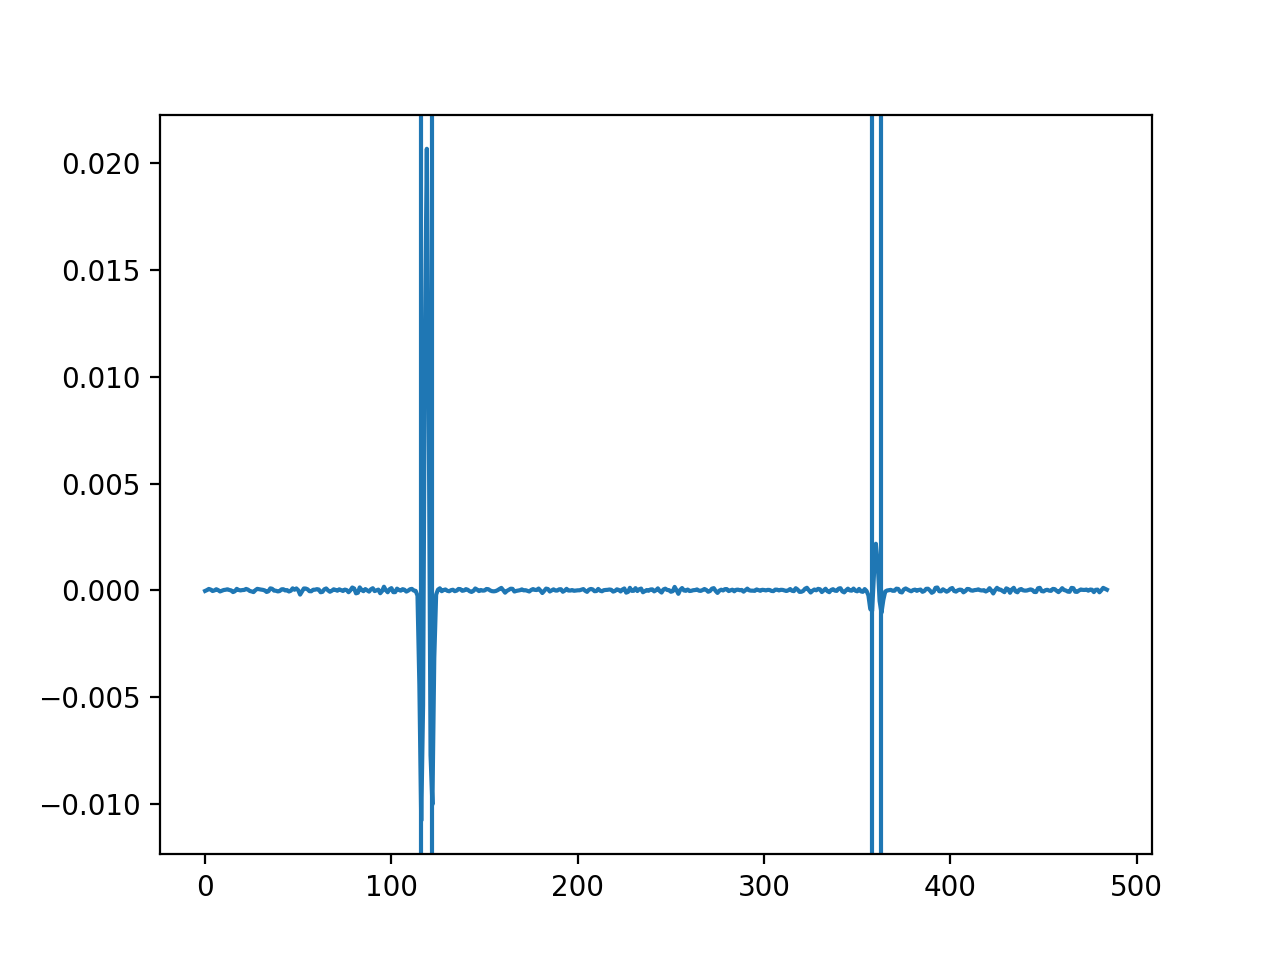

In [51]:
t1_start = process_time()

gradient = np.gradient(np.gradient(sample_fold))
sec = gradient[int(num/2):num]

idx1, idx2 = np.argpartition(gradient[0:int(num/2)], 1)[0:2]
idx3, idx4 = np.argpartition(sec, 1)[0:2] + int(num/2)

#Filter out grazing binaries
insig = False
if sec[idx3 - int(num/2)] > (-3*np.std(sec)):
    insig = True

t1_stop = process_time()
print("Total Computational time (s): ", (t1_stop-t1_start)*1000)
print(insig)
plt.figure()
plt.plot(gradient)
plt.axvline(idx1)
plt.axvline(idx2)
plt.axvline(idx3)
plt.axvline(idx4)

#New Step - Exclude points below some sigma cutoff (3sigma?)
#Needs to include small secondaries but not grazers (e.g. 1661)

0.5833333333333334
0.5625
62255
62255
62255
62255


<IPython.core.display.Javascript object>


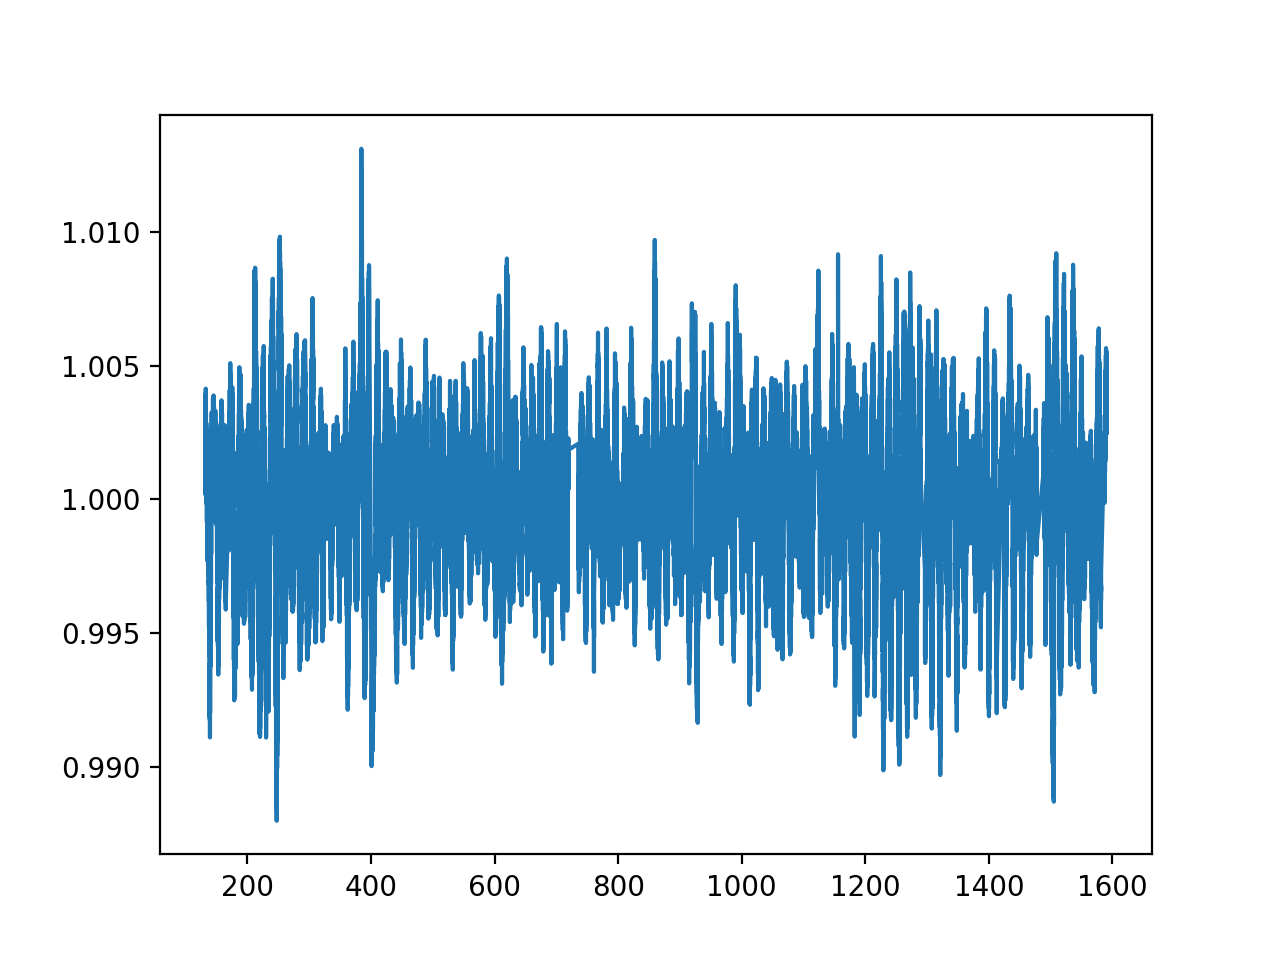

In [39]:
#Get duration of primary's eclipse
dur_prim = (np.abs(idx1 - idx2) + 22)/48
dur_sec = (np.abs(idx3 - idx4) + 22)/48
t0_sec = t0_1 + ((idx4+idx3) - (idx2+idx1))/96

ferr = lc.flux_err.value[clip]

print(dur_prim)
print(dur_sec)

#Make Masks
mask = lc.create_transit_mask(transit_time = [t0_1, t0_sec], period = [p, p], duration = [dur_prim, dur_sec])
mask = mask[clip]

f[mask] = np.random.randn(np.sum(mask)) * ferr[mask] + np.interp(t[mask], t[~mask], f[~mask])

plt.figure()
plt.plot(t,f)
        
#New Step - Smooth over endpoint-to-endpoint all data gaps with linear Gaussian noise